# Semantic Segmentation of Road Networks: A U-Net Implementation

## 1\. Project Context and Initial Setup

This notebook does **binary semantic segmentation** of road networks from satellite imagery. We use **U-Net** architecture. Originally used for bio-medical applications, its symmetric encoder-decoder structure and characteristic **skip connections** make it excellent for precise localization, which is exactly what we need when distinguishing fine road lines from the background here.

| Setting | Value |
| :--- | :--- |
| **Dataset** | DeepGlobe Road Extraction |
| **Goal** | Pixel-wise Road/Non-Road Classification |
| **Input Shape** | 256×256×3 (RGB Image) |
| **Output Shape** | 256×256×1 (Binary Mask) |

-----

## 2\. Environment and Data Configuration

We'll start with the standard imports. NumPy and Pandas for data handling, Matplotlib for visualization, and TensorFlow/Keras for the deep learning. Setting a global seed is standard practice for reproducibility.

In [ ]:
# IMPORTS

# for data manipulation and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for train-validation splitting
from sklearn.model_selection import train_test_split

# for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

# Random Seed
SEED = 24
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-11-24 20:42:44.466477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764016964.488540     225 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764016964.495543     225 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### Hyperparameters & Constants

In [ ]:
# Dimensions
IMAGE_SIZE = 256
CHANNELS = 3 # RGB
MASK_CHANNELS = 1

# Config
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 50

# Path
ROOT_DIR = '/kaggle/input/deepglobe-road-extraction-dataset/'
METADATA_CSV_PATH = os.path.join(ROOT_DIR, 'metadata.csv')

### 2.1 Data Loading and Partitioning

We load the paths and split the training samples into our `train` and `validation` sets (a 90/10 split here) to monitor generalization performance.

In [3]:
# Load Metadata
df = pd.read_csv(METADATA_CSV_PATH)

# Filter for training data
df = df[df['split'] == 'train'].copy()

# Construct full file paths
df['image_path'] = df['sat_image_path'].apply(lambda x: os.path.join(ROOT_DIR, x))
df['mask_path'] = df['mask_path'].apply(lambda x: os.path.join(ROOT_DIR, x))

# Split into Train and Validation (90/10 split)
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=SEED)

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(valid_df)}")

Training Samples: 5603
Validation Samples: 623


### 2.2 The Preprocessing (`process_path`)

We turn file paths into usable, normalized image and mask tensors.

**Key point:** When resizing images, standard bilinear interpolation is fine. However, for the **binary masks**, we must use the **`nearest`** neighbor method to avoid creating non-integer, blurry pixels between 0 and 1, which corrupts the distinct class labels. We also explicitly cast the road pixels to $1.0$ post-normalization.

In [ ]:
# loads and preprocesses one image-mask pair
def process_path(image_path, mask_path):
    


    # ---------------- IMAGE PROCESSING ----------------

    # Read the raw image file from disk
    img = tf.io.read_file(image_path)

    # Decode JPEG image and force 3 channels
    img = tf.image.decode_jpeg(img, channels=CHANNELS)

    # Resize image to a fixed size for uniform model input
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

    # Convert pixel values from int [0,255] to float [0,1]
    # This normalization stabilizes training and speeds up convergence
    img = tf.cast(img, tf.float32) / 255.0  

    
    # ---------------- MASK PROCESSING ----------------
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=MASK_CHANNELS)
    mask = tf.image.resize(mask, [IMAGE_SIZE, IMAGE_SIZE], method='nearest')
    mask = tf.cast(mask, tf.float32) / 255.0
    
    # Binary thresholding to ensure mask is strictly 0 or 1
    mask = tf.where(mask > 0.5, 1.0, 0.0)


    # Return preprocessed image and mask pair
    # Image: [256, 256, 3] float32
    # Mask : [256, 256, 1] binary {0,1}
    return img, mask

def create_dataset(df, batch_size=32, shuffle=False):
    """
    Creates a highly optimized tf.data.Dataset pipeline.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['mask_path'].values))
    
    # Shuffle if training
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    # Map the loading function in parallel
    dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # Batch and Prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# Initialize Datasets
train_ds = create_dataset(train_df, BATCH_SIZE, shuffle=True)
valid_ds = create_dataset(valid_df, BATCH_SIZE, shuffle=False)

I0000 00:00:1764016969.392330     225 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764016969.392990     225 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Visualization

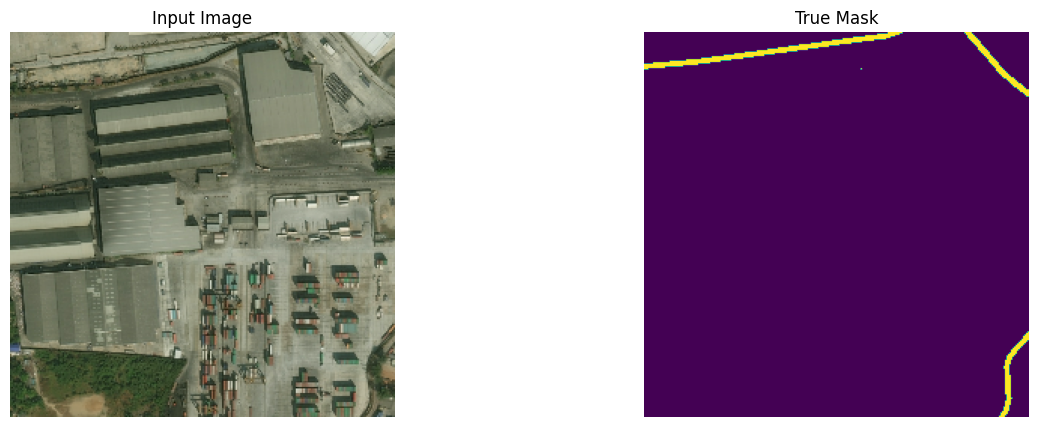

In [5]:
def display_sample(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Show a random batch
for image, mask in train_ds.take(1):
    display_sample([image[0], mask[0]])

## 3\. Evaluation Metrics and Loss Function

For segmentation, simple pixel accuracy was useless because the background (non-road) class typically dominates. We therefore use metrics that specifically penalize poor overlap with the target (road) class.

### 3.1 Intersection over Union (IoU) and Dice Coefficient

We focus on the **Jaccard Index ($\mathcal{J}$), also known as IoU**, and the **Dice Coefficient ($\mathcal{D}$)**, which is equivalent to the $F_1$ score. Both are preferred for imbalanced segmentation tasks.

**Jaccard Index (IoU):** This measures the size of the intersection divided by the size of the union of the true mask ($Y$) and the predicted mask ($\hat{Y}$). It is a stricter metric than the Dice Coefficient.

$$\mathcal{J}(Y, \hat{Y}) = \frac{|Y \cap \hat{Y}|}{|Y \cup \hat{Y}|} = \frac{|Y \cap \hat{Y}|}{|Y| + |\hat{Y}| - |Y \cap \hat{Y}|}$$

**Dice Coefficient ($\mathcal{D}$):** Often used interchangeably with IoU, it's defined as twice the area of overlap divided by the total number of pixels in both sets.

$$\mathcal{D}(Y, \hat{Y}) = \frac{2 |Y \cap \hat{Y}|}{|Y| + |\hat{Y}|}$$

### 3.2 Dice Loss Implementation

To directly optimize for our target metric, we use **Dice Loss** ($L_{Dice}$), defined simply as $1 - \mathcal{D}$. This promotes maximizing the Dice Coefficient. A small $\epsilon$ (smooth term) is added for numerical stability, especially when one or both masks are entirely empty.


In [6]:
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

## 4\. U-Net Architecture Construction

The U-Net is essentially an encoder-decoder network connected by skip connections.

The **Encoder (Contracting Path)** captures context and downsamples, while the **Decoder (Expanding Path)** uses the abstracted features to precisely localize the segmentation border.

### 4.1 The Building Block (`ConvBlock`)

Our basic feature extraction unit is a double-convolution block. We use two $3 \times 3$ convolutions, each followed by **Batch Normalization** (critical for stable training) and a ReLU activation.

### 4.2 The Full U-Net Model

The model descends from 256x256 to 16x16 pixels and then symmetrically ascends back up. The core architectural feature is the **concatenation** layer (`uX = layers.concatenate([uX, cY])`), which merges high-resolution features from the encoder (`cY`) with the upsampled, contextual features from the decoder (`uX`). This is what allows U-Net to nail the precise spatial boundaries.

### Model Summary

The model has approximately 31 million parameters, which is substantial but manageable for a high-resolution segmentation task.

In [7]:
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    p = layers.Dropout(0.3)(p)
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, skip_tensor])
    x = layers.Dropout(0.3)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    
    # Bridge
    b1 = conv_block(p4, 512)
    
    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)
    
    # Output
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)
    
    model = models.Model(inputs, outputs, name="U-Net")
    return model

model = build_unet((IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## 5\. Training and Results

### 5.1 Compilation and Callbacks

We compile the model using the **Adam optimizer** and our custom `dice_loss` function. We use standard callbacks to ensure the training is robust:

1.  **`ModelCheckpoint`**: Saves the best weights (based on validation IoU).
2.  **`ReduceLROnPlateau`**: Cuts the learning rate by $50\%$ if validation loss stalls for 5 epochs.
3.  **`EarlyStopping`**: Stops training if the loss doesn't improve for 10 epochs.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou_coef, 'accuracy']
)

# Callbacks
callbacks = [
    # Monitor val_dice_coef, saving the model when the value is MAXIMIZED
    tf.keras.callbacks.ModelCheckpoint(
        'road_segmentation.keras', 
        save_best_only=True, 
        monitor='val_dice_coef', 
        mode='max' # <--- ADDED MODE='MAX'
    ), 
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6
    ),
    # Monitor val_dice_coef, stopping early when the value fails to increase
    tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coef', 
        patience=10, 
        restore_best_weights=True,
        mode='max' # <--- ADDED MODE='MAX'
    )
]

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1764016983.971040     260 service.cc:148] XLA service 0x7a2c2c002260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764016983.971074     260 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764016983.971078     260 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764016985.957941     260 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-24 20:43:39.494214: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9303 - dice_coef: 0.0850 - iou_coef: 0.0444 - loss: 0.2599

E0000 00:00:1764017171.553027     260 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764017171.780980     260 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


176/176 ━━━━━━━━━━━━━━━━━━━━ 236s 916ms/step - accuracy: 0.9306 - dice_coef: 0.0851 - iou_coef: 0.0445 - loss: 0.2591 - val_accuracy: 0.9594 - val_dice_coef: 0.0290 - val_iou_coef: 0.0147 - val_loss: 0.1840 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 122s 694ms/step - accuracy: 0.9575 - dice_coef: 0.1188 - iou_coef: 0.0632 - loss: 0.1456 - val_accuracy: 0.9594 - val_dice_coef: 0.0337 - val_iou_coef: 0.0171 - val_loss: 0.1820 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 121s 689ms/step - accuracy: 0.9597 - dice_coef: 0.2048 - iou_coef: 0.1147 - loss: 0.1238 - val_accuracy: 0.9595 - val_dice_coef: 0.0540 - val_iou_coef: 0.0278 - val_loss: 0.1776 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 122s 690ms/step - accuracy: 0.9635 - dice_coef: 0.3231 - iou_coef: 0.1930 - loss: 0.1045 - val_accuracy: 0.9651 - val_dice_coef: 0.3090 - val_iou_coef: 0.1832 - val_loss: 0.1120 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 122

### Plots


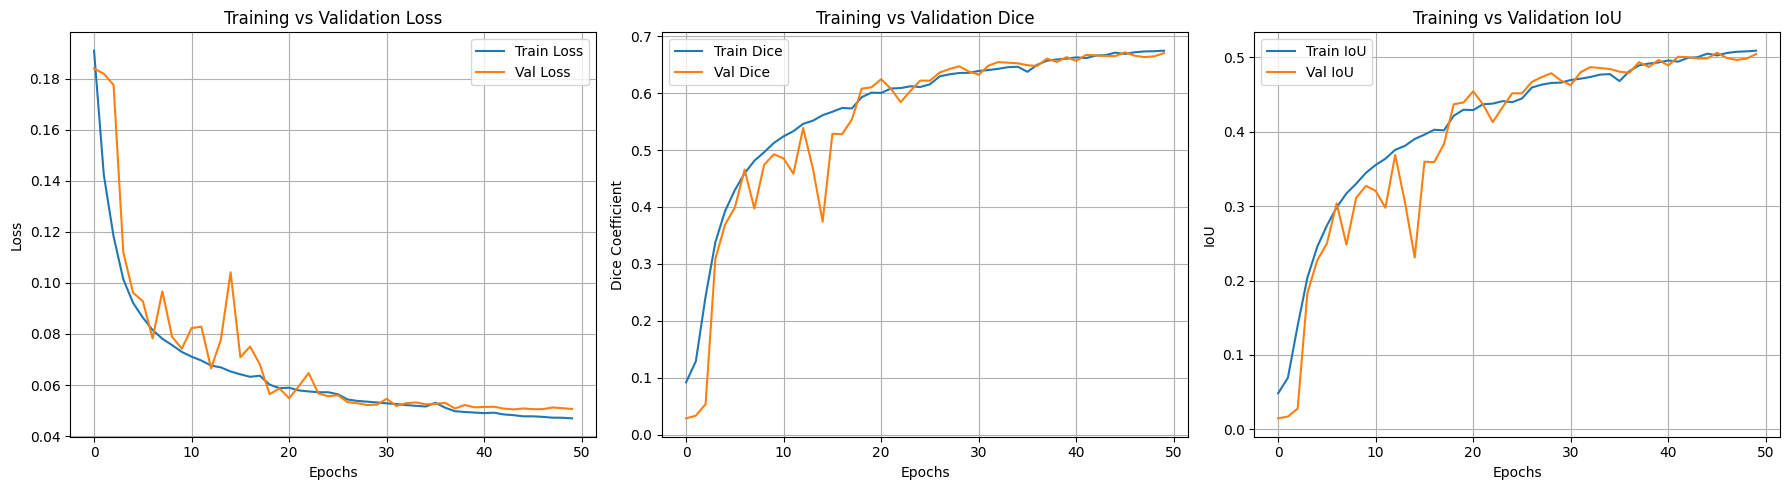

In [9]:
plt.figure(figsize=(18,5))

# LOSS
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# DICE
plt.subplot(1,3,2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training vs Validation Dice')
plt.legend()
plt.grid(True)

# IOU
plt.subplot(1,3,3)
plt.plot(history.history['iou_coef'], label='Train IoU')
plt.plot(history.history['val_iou_coef'], label='Val IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training vs Validation IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
import json

with open("training_history.json", "w") as f:
    json.dump(history.history, f)

print("✅ Training history saved as training_history.json")


✅ Training history saved as training_history.json


In [12]:
print("Final Validation Results:")
results = model.evaluate(valid_ds)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


Final Validation Results:
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9807 - dice_coef: 0.6769 - iou_coef: 0.5123 - loss: 0.0508
loss: 0.0505
compile_metrics: 0.6716


## Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


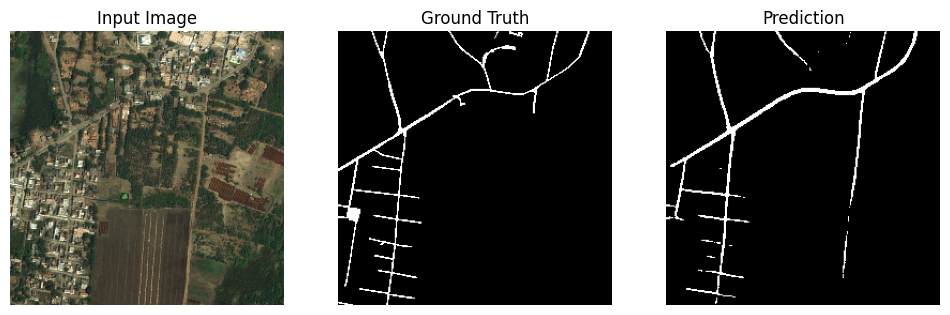

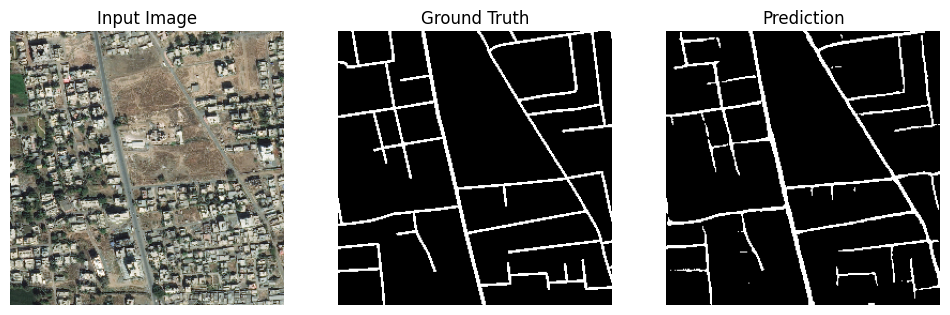

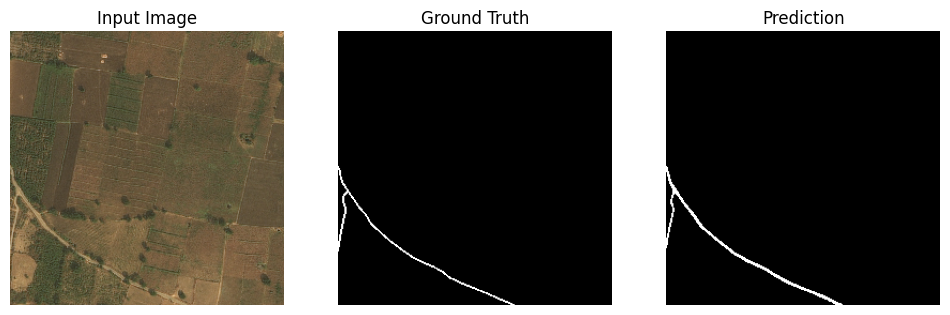

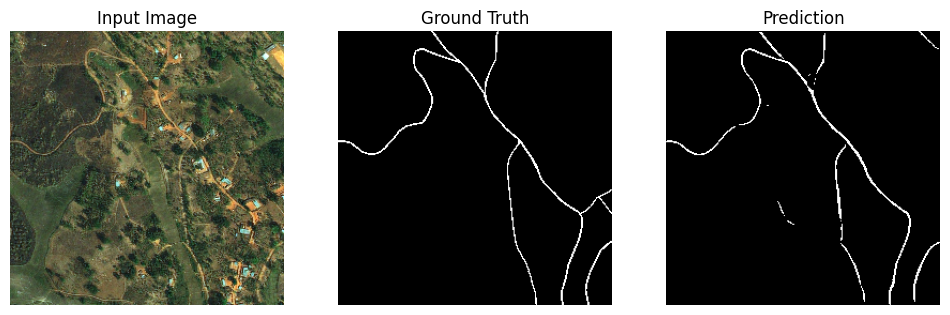

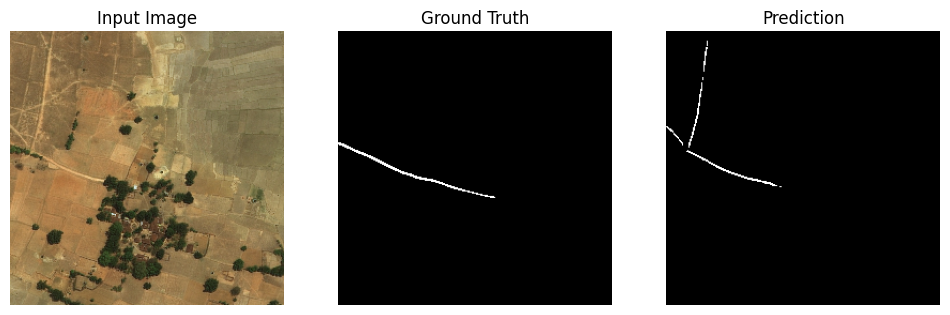

In [17]:
import random

def visualize_predictions(dataset, num_samples=5):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = tf.where(preds > 0.5, 1.0, 0.0)

        batch_size = images.shape[0]
        random_indices = random.sample(range(batch_size), num_samples)

        for i in random_indices:
            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(tf.squeeze(preds[i]), cmap='gray')
            plt.title("Prediction")
            plt.axis("off")

            plt.show()

visualize_predictions(valid_ds, num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


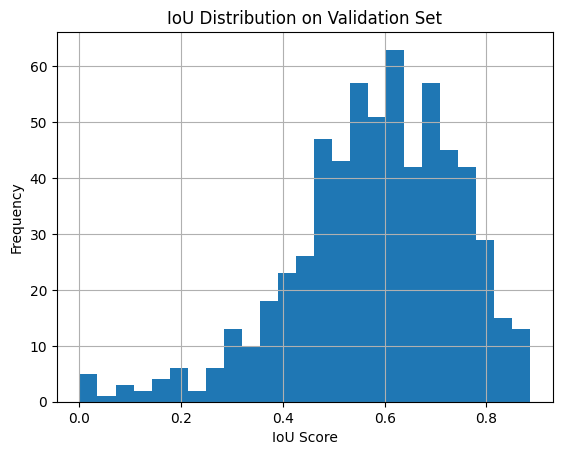

✅ IoU scores saved


In [18]:
import numpy as np

ious = []

for images, masks in valid_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.float32)

    intersection = tf.reduce_sum(preds * masks, axis=[1,2,3])
    union = tf.reduce_sum(preds + masks, axis=[1,2,3]) - intersection
    batch_iou = intersection / (union + 1e-7)

    ious.extend(batch_iou.numpy())

plt.hist(ious, bins=25)
plt.xlabel("IoU Score")
plt.ylabel("Frequency")
plt.title("IoU Distribution on Validation Set")
plt.grid(True)
plt.show()

np.save("iou_scores.npy", ious)
print("✅ IoU scores saved")


In [19]:
model.save("final_unet_model.keras")
print("✅ Model saved successfully")

# Also save metrics text
with open("final_metrics.txt", "w") as f:
    for name, value in zip(model.metrics_names, results):
        f.write(f"{name}: {value:.4f}\n")

print("✅ Metrics saved to final_metrics.txt")


✅ Model saved successfully
✅ Metrics saved to final_metrics.txt
